Validation RMSE: 5.563157384009658
Testing RMSE: 5.773685676488338
MAE: 4.64250443571441
MAPE: 28.955733556852575


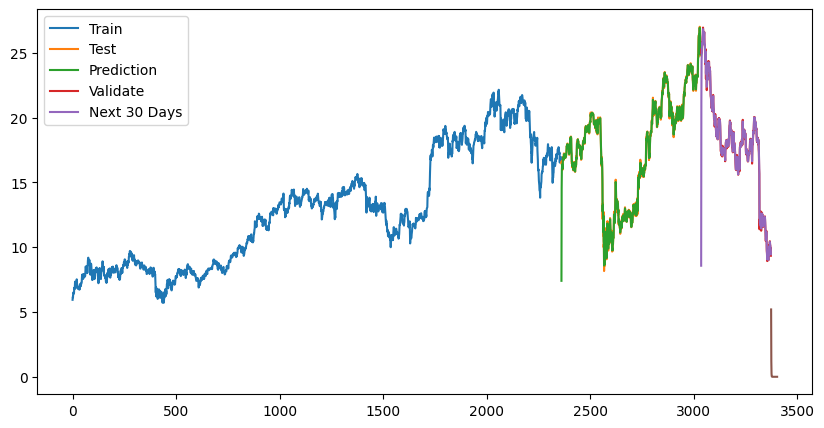

In [2]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Đọc dữ liệu từ file
df = pd.read_csv('E:/Nam3/HK2/Business_Analyst/github/BDLM/Bayesian_Dynamic_linear_Model/dataset/KEY.csv')
df = df[['Close']]
df = df.dropna()
df = df.reset_index(drop=True)

# Chia dữ liệu thành tập train, test và validate
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close']).reshape(-1, 1)

# Tạo mô hình Kalman Filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=1)

# Xác định ma trận chuyển đổi và ma trận quan sát
transition_matrix = np.array([[1]])
observation_matrix = np.array([[1]])

# Xác định ma trận hiệp phương sai của quá trình chuyển đổi và quan sát
transition_covariance = np.eye(1)
observation_covariance = np.eye(1) * 0.1

# Xác định giá trị ban đầu của trạng thái
initial_state_mean = y_train[0]
initial_state_covariance = np.eye(1)

# Thiết lập các tham số cho mô hình
kf.transition_matrices = transition_matrix
kf.observation_matrices = observation_matrix
kf.transition_covariance = transition_covariance
kf.observation_covariance = observation_covariance
kf.initial_state_mean = initial_state_mean
kf.initial_state_covariance = initial_state_covariance

# Huấn luyện mô hình
kf.em(y_train)

# Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close']).reshape(-1, 1)
predicted_state_means, _ = kf.filter(y_test)

# Dự đoán dữ liệu
y_pred = predicted_state_means[:, 0]

# Quá trình Validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close']).reshape(-1, 1)
predicted_val_state_means, _ = kf.filter(y_val)

# Dự đoán dữ liệu validate
y_pred_val = predicted_val_state_means[:, 0]

# Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31))

# Dự đoán 30 ngày tiếp theo
predicted_next_state_means, _ = kf.filter(np.zeros_like(x_next_30_days))
y_next_30_days = predicted_next_state_means[:, 0]

# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mae = np.mean(np.abs(y_pred - y_test))
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('MAE:', mae)
print('MAPE:', mape)

# Vẽ hình
plt.figure(figsize =(10, 5))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(x_next_30_days, y_next_30_days)
plt.legend(['Train', 'Test',  'Prediction', 'Validate', 'Next 30 Days'])
plt.show()